In [59]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns 
import pandas as pd
import pickle
import scipy.stats as stats 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, fbeta_score, f1_score, roc_curve, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import  SVC

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import torch.nn as nn


from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential

In [2]:
data = pd.read_csv("cs98x-22-dl-task2/train.csv")
data.drop( labels= ['id'], axis= 1, inplace= True )
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,16,U,GT3,A,0,3,teacher,services,...,5,4,2,1,0,4,2,8,13,7
1,MS,M,17,U,GT3,T,4,0,other,services,...,4,2,4,2,2,1,28,12,10,12
2,MS,F,17,U,LE3,T,1,0,services,at_home,...,4,4,2,1,2,2,3,11,9,8
3,GP,M,17,R,LE3,T,2,2,health,other,...,2,4,2,2,2,4,2,16,15,9
4,MS,F,14,R,LE3,T,0,1,health,teacher,...,3,3,2,2,1,4,0,9,14,8


In [3]:
# Size of data set
data.shape

(20064, 33)

In [4]:
# see the number of null values 
for feature_name in data.columns:
    print(f"{feature_name} -> {data[feature_name].isna().sum()}")

school -> 0
sex -> 0
age -> 0
address -> 0
famsize -> 0
Pstatus -> 0
Medu -> 0
Fedu -> 0
Mjob -> 0
Fjob -> 0
reason -> 0
guardian -> 0
traveltime -> 0
studytime -> 0
failures -> 0
schoolsup -> 0
famsup -> 0
paid -> 0
activities -> 0
nursery -> 0
higher -> 0
internet -> 0
romantic -> 0
famrel -> 0
freetime -> 0
goout -> 0
Dalc -> 0
Walc -> 0
health -> 0
absences -> 0
G1 -> 0
G2 -> 0
Grade -> 0


In [5]:
# Label Encode the Values

la_dct = {}
for i in data.select_dtypes(np.object_).columns:
    la_dct[i] = LabelEncoder().fit(data[i].values)
    
    data[i] = la_dct[i].transform(data[i].values)
    
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,0,0,16,1,0,0,0,3,4,3,...,5,4,2,1,0,4,2,8,13,7
1,1,1,17,1,0,1,4,0,2,3,...,4,2,4,2,2,1,28,12,10,12
2,1,0,17,1,1,1,1,0,3,0,...,4,4,2,1,2,2,3,11,9,8
3,0,1,17,0,1,1,2,2,1,2,...,2,4,2,2,2,4,2,16,15,9
4,1,0,14,0,1,1,0,1,1,4,...,3,3,2,2,1,4,0,9,14,8


(20064, 33)

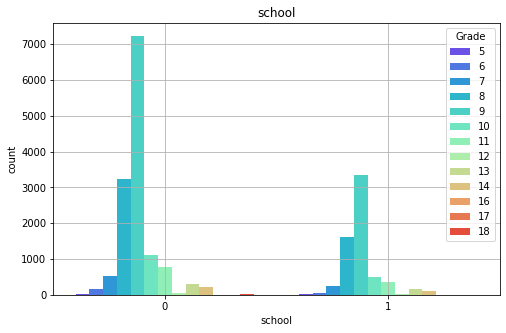

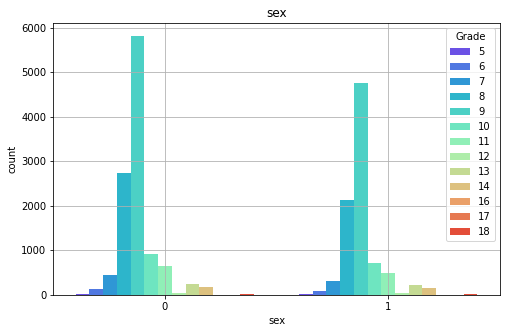

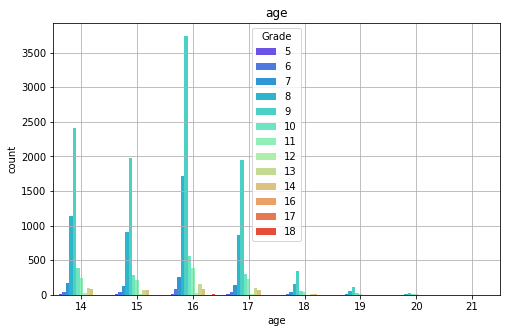

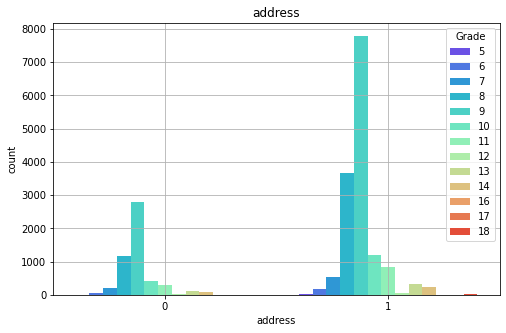

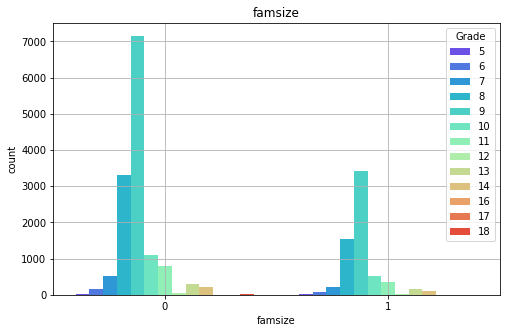

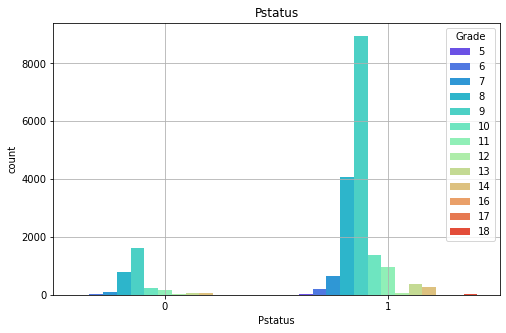

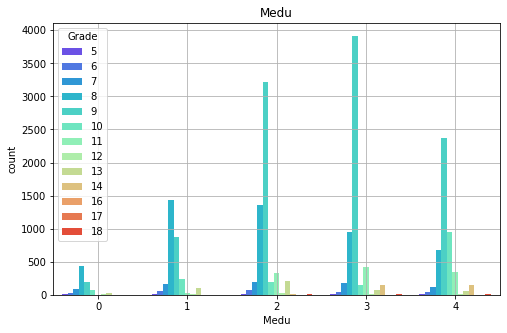

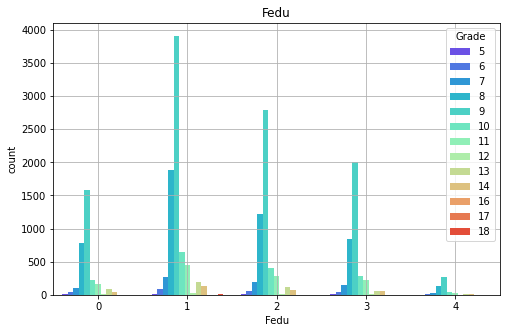

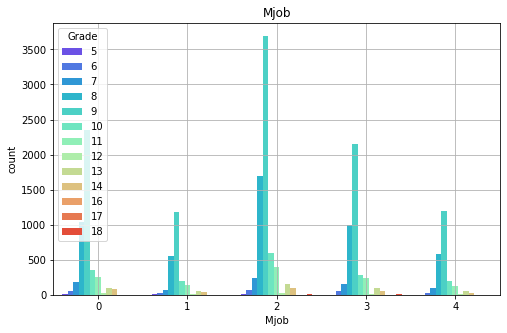

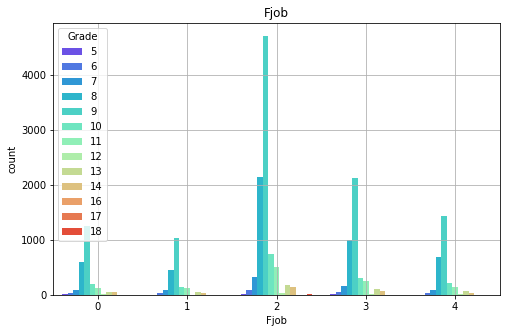

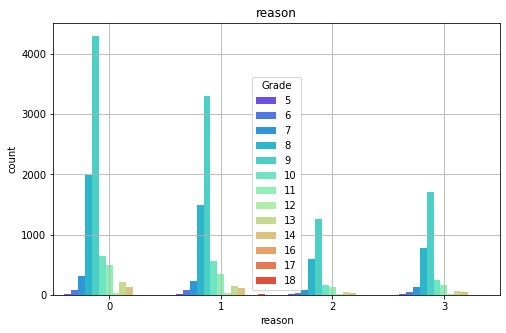

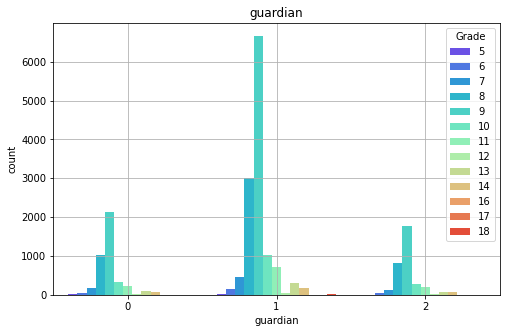

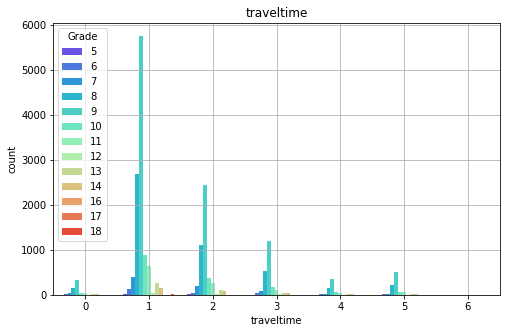

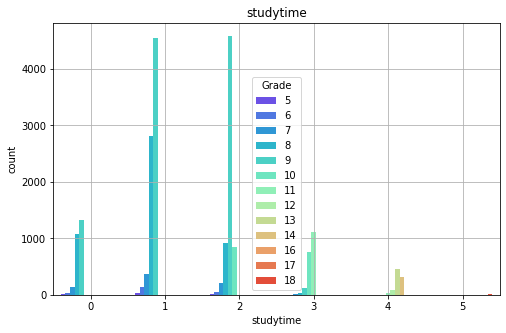

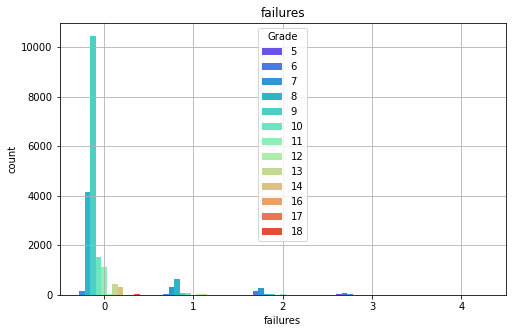

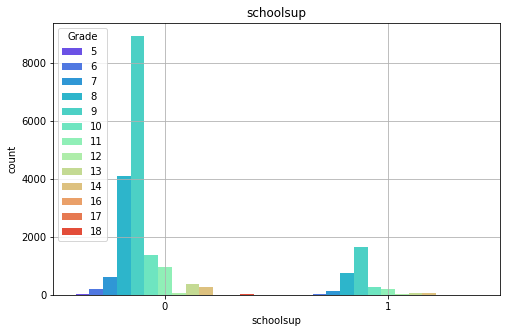

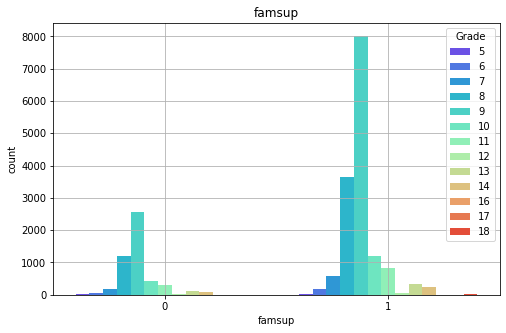

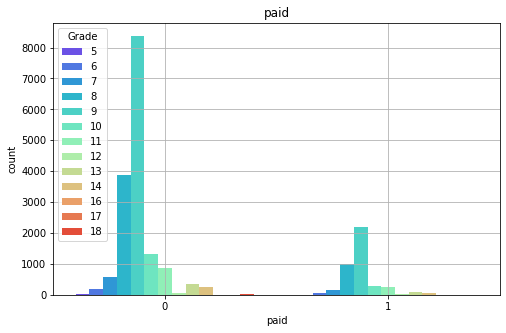

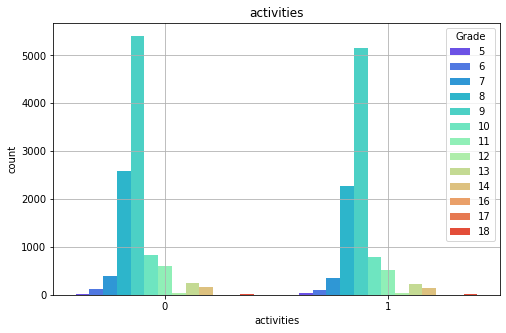

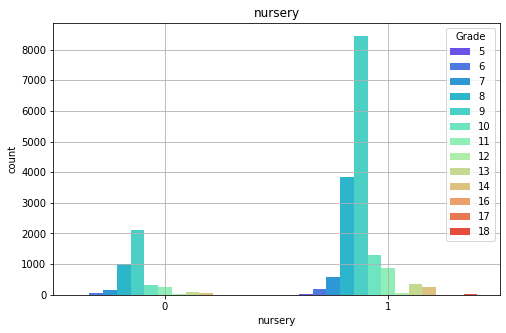

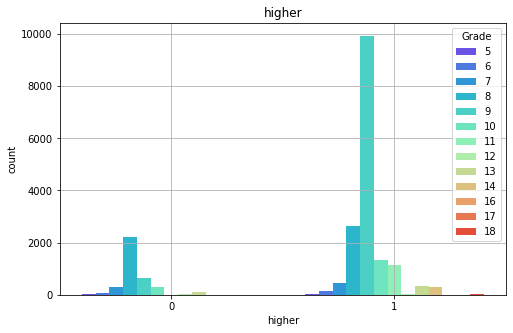

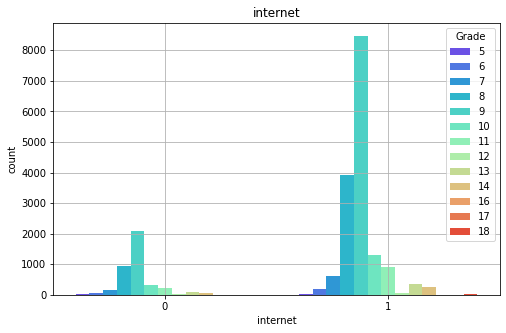

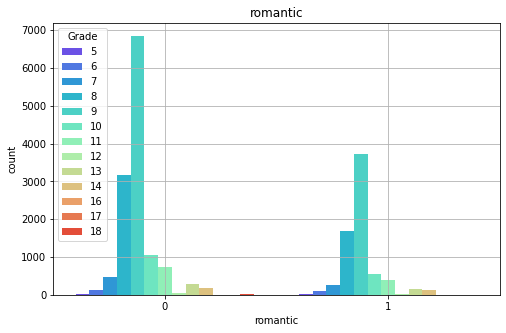

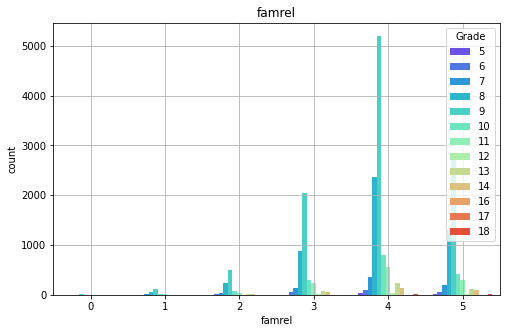

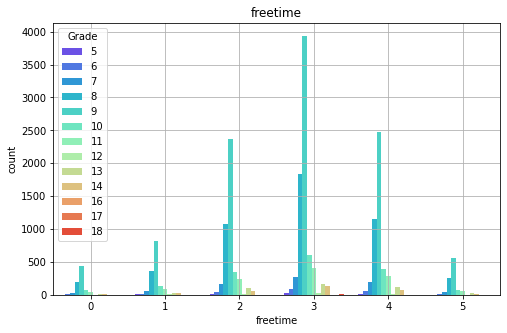

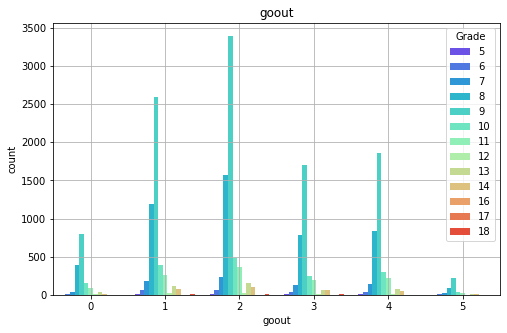

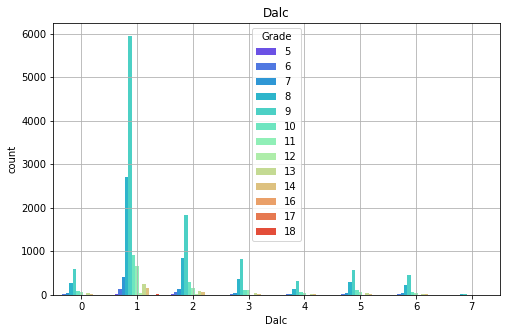

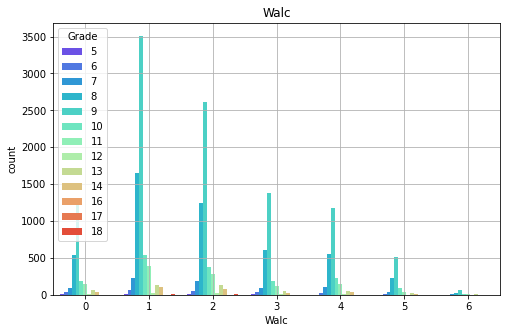

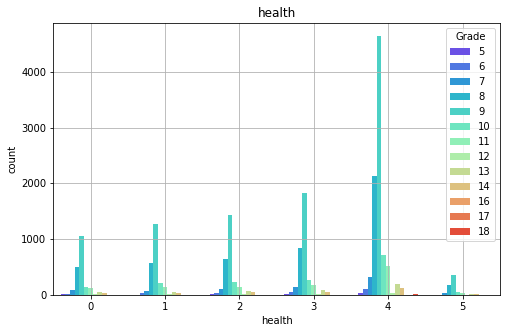

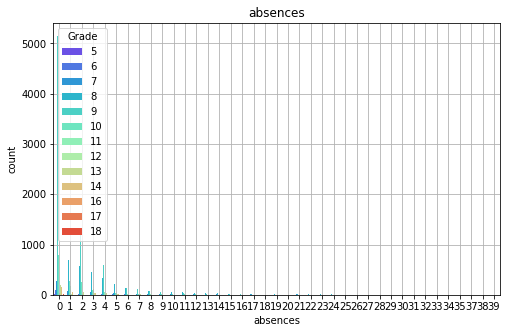

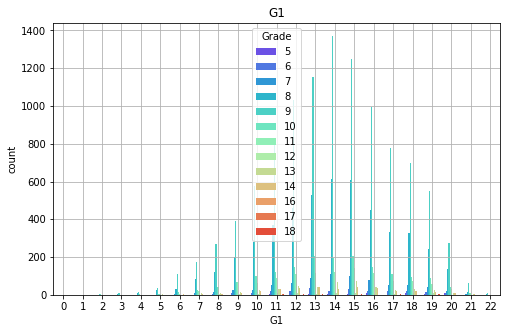

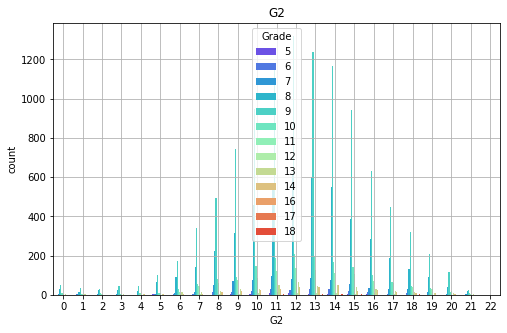

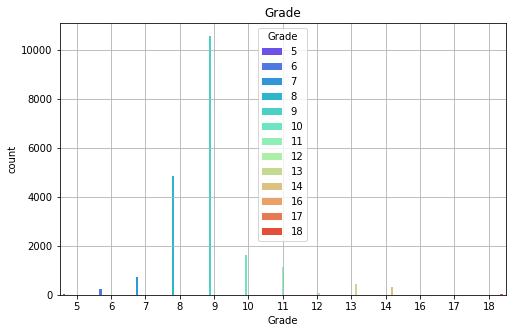

In [8]:
# Data Distribution 
for colm in data.columns:

    plt.figure(figsize=(8,5))
    sns.countplot(x=colm ,data=data, palette='rainbow',hue="Grade" )
    plt.title(colm)
    plt.grid()
    plt.show()
    

In [9]:
# As the 
# data.drop(labels= ['absences'], axis = 1, inplace= True)

In [10]:
data.Grade.nunique()

13

9     10564
8      4857
10     1616
11     1133
7       746
13      456
14      310
6       229
12       80
5        47
18       19
17        5
16        2
Name: Grade, dtype: int64



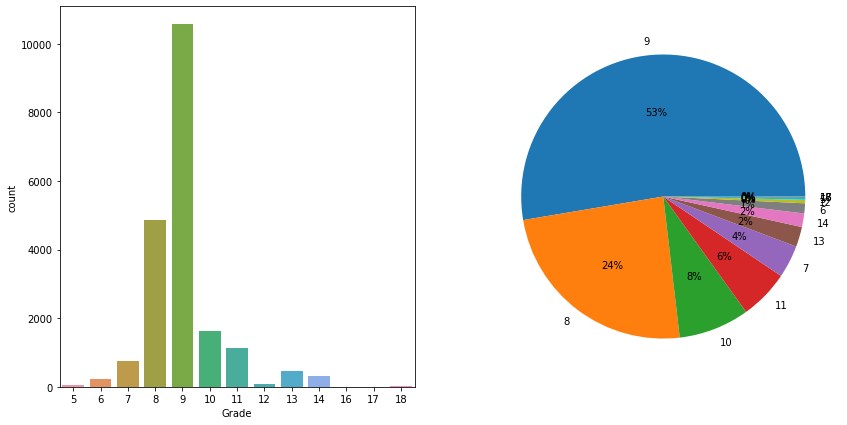

In [10]:
# Class distribution of Output/dependent feature

print( data['Grade'].value_counts() )
print()

plt.figure(figsize= (14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x = 'Grade' , data = data)

plt.subplot(1, 2, 2)
plt.pie(data['Grade'].value_counts() , labels= [ i for i in data['Grade'].value_counts().keys() ], autopct='%.0f%%')

plt.show()

5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
16    2000
17    2000
18    2000
Name: Grade, dtype: int64



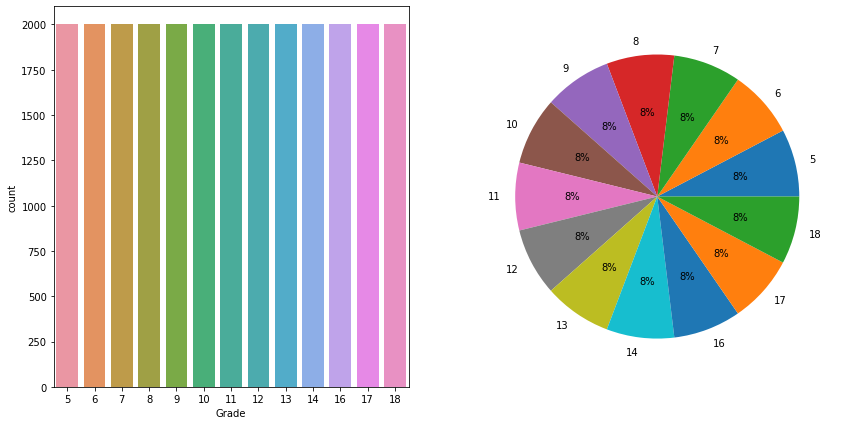

In [11]:
n_samples=int(2000)

def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy


# under sampling 
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(data.iloc[:,:-1],data.iloc[:,-1],n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(data.iloc[:,:-1],data.iloc[:,-1])

# over sampling
over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'),k_neighbors=1)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)


data = X_bal.copy()
data['Grade'] = y_bal

print( data['Grade'].value_counts() )
print()

plt.figure(figsize= (14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x = 'Grade' , data = data)

plt.subplot(1, 2, 2)
plt.pie(data['Grade'].value_counts() , labels= [ i for i in data['Grade'].value_counts().keys() ], autopct='%.0f%%')

plt.show()

In [12]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,0,0,16,0,1,1,3,3,0,2,...,5,2,3,3,2,1,0,16,9,5
1,1,1,15,1,0,1,3,2,2,2,...,3,3,4,3,2,0,6,19,5,5
2,0,1,16,1,1,1,2,1,0,3,...,4,3,1,4,5,4,3,18,10,5
3,0,0,19,1,0,1,2,0,2,0,...,5,4,4,2,1,2,4,12,11,5
4,1,0,17,1,0,1,1,2,2,2,...,3,0,0,6,3,5,10,20,4,5


## Data Normalisation

In [15]:
data.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,...,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,26000.000000
mean,5.684342e-17,-1.967657e-17,6.668170e-16,-7.651999e-18,-7.105427e-18,-1.224320e-16,1.486674e-16,3.019807e-17,3.498057e-17,-8.745141e-17,...,4.809828e-17,1.727165e-16,-5.684342e-17,-8.089256e-17,8.171241e-17,-1.093143e-16,-3.060799e-17,1.268045e-16,2.186285e-18,11.230769
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,...,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,4.060276
min,-3.998572e-01,-6.202794e-01,-1.360600e+00,-1.197022e+00,-4.104714e-01,-1.820221e+00,-2.080901e+00,-1.399036e+00,-1.455374e+00,-1.810733e+00,...,-5.024947e+00,-2.673327e+00,-1.643214e+00,-1.191536e+00,-1.385754e+00,-1.988498e+00,-5.637001e-01,-4.436983e+00,-2.829516e+00,5.000000
25%,-3.998572e-01,-6.202794e-01,-4.308131e-01,-1.197022e+00,-4.104714e-01,5.493838e-01,-2.221238e-01,-2.674468e-01,-5.549211e-01,-8.416491e-01,...,-1.036650e+00,-6.244381e-01,-8.064653e-01,-4.354116e-01,-5.862334e-01,-5.418724e-01,-5.637001e-01,-8.587609e-01,-6.341655e-01,8.000000
50%,-3.998572e-01,-6.202794e-01,4.989736e-01,8.354063e-01,-4.104714e-01,5.493838e-01,-2.221238e-01,-2.674468e-01,3.455313e-01,1.274345e-01,...,2.927819e-01,4.000061e-01,3.028388e-02,-4.354116e-01,2.132876e-01,1.814402e-01,-3.467447e-01,1.171180e-01,9.761804e-02,11.000000
75%,-3.998572e-01,1.612177e+00,4.989736e-01,8.354063e-01,-4.104714e-01,5.493838e-01,7.072646e-01,8.641426e-01,3.455313e-01,1.274345e-01,...,2.927819e-01,4.000061e-01,8.670331e-01,3.207132e-01,2.132876e-01,9.047528e-01,8.716599e-02,7.677039e-01,5.854737e-01,14.000000
max,2.500893e+00,1.612177e+00,4.218121e+00,8.354063e-01,2.436223e+00,5.493838e-01,1.636653e+00,3.127322e+00,2.146436e+00,2.065602e+00,...,1.622214e+00,2.448894e+00,2.540531e+00,4.101337e+00,3.411372e+00,1.628065e+00,7.897559e+00,2.719462e+00,2.536896e+00,18.000000


In [16]:
# scaling and normalisation 

scalar = StandardScaler()

independent_fea = data.columns[:-1] 

for i in independent_fea:
    data[i] = scalar.fit_transform(data[i].values.reshape(-1,1))

data.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,...,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,2.600000e+04,26000.000000,2.600000e+04,2.600000e+04,26000.000000
mean,1.311771e-17,4.372571e-18,-6.340227e-17,-7.651999e-18,-7.105427e-18,1.749028e-17,-3.060799e-17,2.937821e-17,-1.530400e-17,4.372571e-18,...,-1.749028e-17,-2.186285e-17,2.295600e-17,-6.121599e-17,7.515356e-18,-3.060799e-17,0.000000,-1.749028e-17,-4.372571e-18,11.230769
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,...,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019,1.000019e+00,1.000019e+00,4.060276
min,-3.998572e-01,-6.202794e-01,-1.360600e+00,-1.197022e+00,-4.104714e-01,-1.820221e+00,-2.080901e+00,-1.399036e+00,-1.455374e+00,-1.810733e+00,...,-5.024947e+00,-2.673327e+00,-1.643214e+00,-1.191536e+00,-1.385754e+00,-1.988498e+00,-0.563700,-4.436983e+00,-2.829516e+00,5.000000
25%,-3.998572e-01,-6.202794e-01,-4.308131e-01,-1.197022e+00,-4.104714e-01,5.493838e-01,-2.221238e-01,-2.674468e-01,-5.549211e-01,-8.416491e-01,...,-1.036650e+00,-6.244381e-01,-8.064653e-01,-4.354116e-01,-5.862334e-01,-5.418724e-01,-0.563700,-8.587609e-01,-6.341655e-01,8.000000
50%,-3.998572e-01,-6.202794e-01,4.989736e-01,8.354063e-01,-4.104714e-01,5.493838e-01,-2.221238e-01,-2.674468e-01,3.455313e-01,1.274345e-01,...,2.927819e-01,4.000061e-01,3.028388e-02,-4.354116e-01,2.132876e-01,1.814402e-01,-0.346745,1.171180e-01,9.761804e-02,11.000000
75%,-3.998572e-01,1.612177e+00,4.989736e-01,8.354063e-01,-4.104714e-01,5.493838e-01,7.072646e-01,8.641426e-01,3.455313e-01,1.274345e-01,...,2.927819e-01,4.000061e-01,8.670331e-01,3.207132e-01,2.132876e-01,9.047528e-01,0.087166,7.677039e-01,5.854737e-01,14.000000
max,2.500893e+00,1.612177e+00,4.218121e+00,8.354063e-01,2.436223e+00,5.493838e-01,1.636653e+00,3.127322e+00,2.146436e+00,2.065602e+00,...,1.622214e+00,2.448894e+00,2.540531e+00,4.101337e+00,3.411372e+00,1.628065e+00,7.897559,2.719462e+00,2.536896e+00,18.000000


In [17]:
# shuffle the data 
data = data.sample(n = data.shape[0])

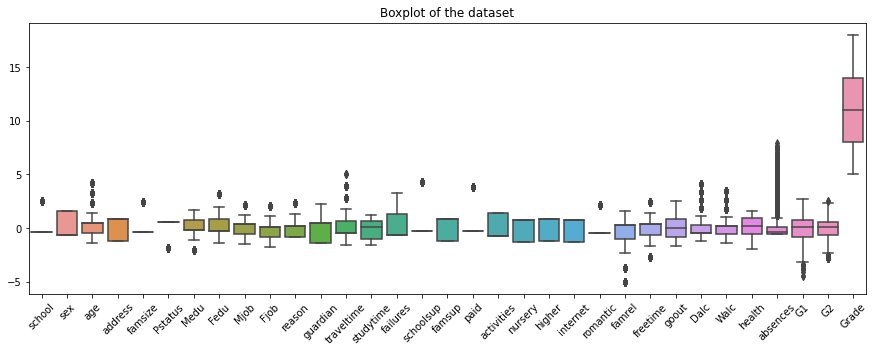

In [18]:
#outliers in the dataset

plt.figure(figsize=(15,5))
sns.boxplot(data=data)
plt.xticks(rotation = 45)
plt.title('Boxplot of the dataset')
plt.show()

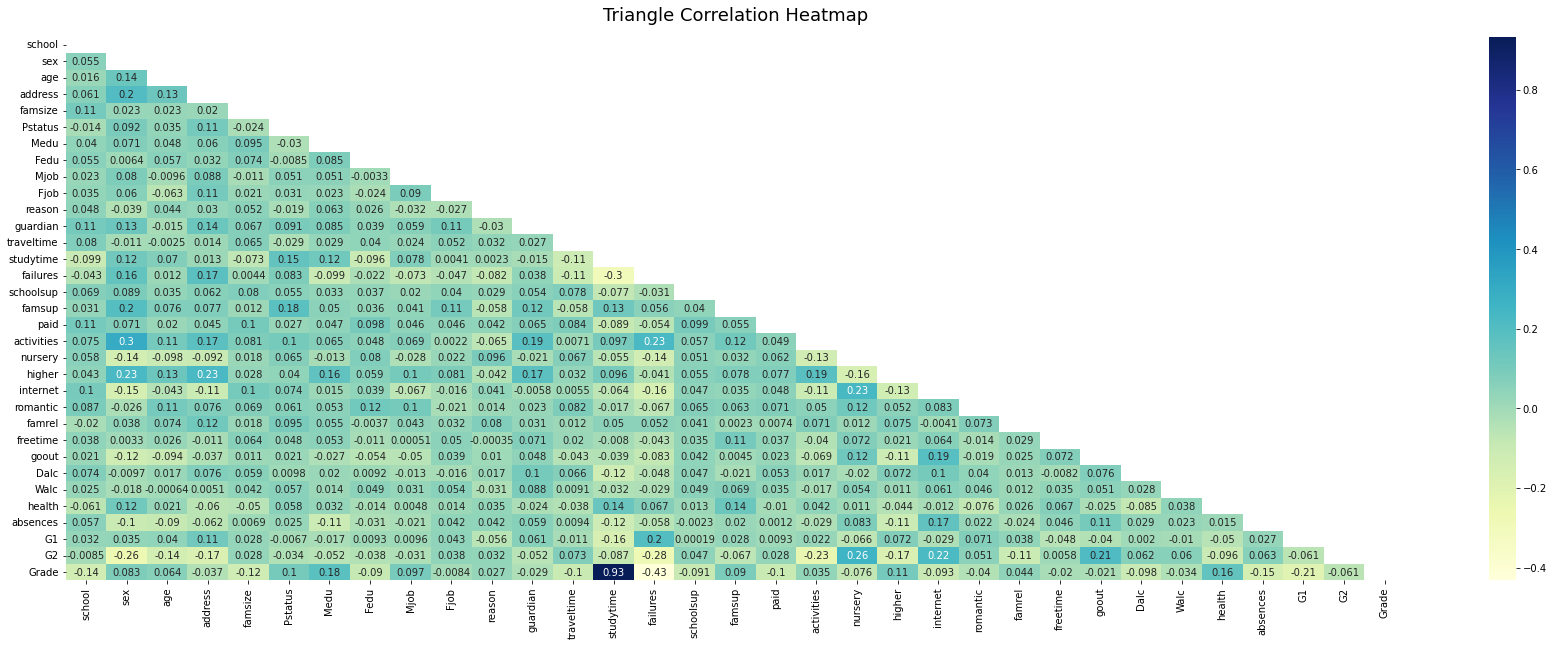

In [19]:
# Corelation Matrix

plt.figure(figsize = (30,10))

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, annot=True, cmap="YlGnBu")

heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

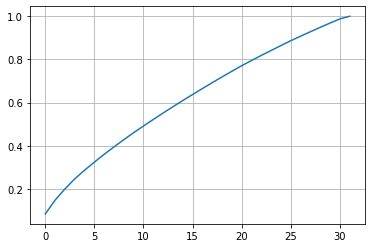

In [20]:
# Feature Extraction

pca = PCA(n_components= None)
pca.fit_transform(data.iloc[:, :-1].values)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.show()

In [21]:
# cummuliative sum of varience 

np.cumsum(pca.explained_variance_ratio_)

array([0.08398411, 0.14798961, 0.19978093, 0.24639483, 0.28656427,
       0.32396128, 0.36014622, 0.3948871 , 0.42796376, 0.46033111,
       0.49136243, 0.52168363, 0.55153233, 0.58076146, 0.60922056,
       0.63730282, 0.66491171, 0.69215823, 0.71881316, 0.7450388 ,
       0.77074941, 0.79473434, 0.81850675, 0.84136951, 0.8640904 ,
       0.8864955 , 0.9076312 , 0.92820859, 0.94853526, 0.96834611,
       0.98747967, 1.        ])

In [22]:
# split the data 
X_train, X_test, y_train, y_test = train_test_split( data.iloc[:, :-1].values, data.iloc[:, -1].values, test_size=0.20)

# Model Training and Analysis 

In [23]:
# Collection of fpr and tpr for various models 
ROC_Values = dict()

def classification_Report(model ,y_pred, model_name):
    """
    input  : object of the model, predicted
    output : returns various metrics to understand model performance 
    """
    
    # sklearns classification report function
    print( classification_report(y_test ,y_pred) )
    
    # Confusion matrix
    plt.figure(figsize= (15,15))
    cf_matrix = confusion_matrix(y_test, y_pred)
    hm = sns.heatmap((cf_matrix/np.sum(cf_matrix))*2 , annot=True, fmt='.2%', xticklabels=[ i for i in data.Grade.unique() ], yticklabels=[ i for i in data.Grade.unique() ])
    hm.set_xlabel("Predicted Values", fontsize = 15)
    hm.set_ylabel("Actual Values", fontsize = 15)
    plt.show()
    

In [24]:
def model_Trainer(model_obj, model_name):
    """
    input:
        model_obj  : object of our model 
        model_name : string input 
    returns:
        Generates predictions and classification report
        trained model
    """
    model_obj.fit(X_train, y_train)
    
    y_pred = model_obj.predict(X_test)

    classification_Report(model_obj, y_pred ,model_name)
    
    return model_obj

### 4.2 Machine Learning Approaches

              precision    recall  f1-score   support

           5       0.99      1.00      0.99       361
           6       0.97      0.98      0.98       407
           7       0.92      0.93      0.92       375
           8       0.78      0.79      0.78       409
           9       0.85      0.80      0.83       430
          10       0.97      0.98      0.97       408
          11       0.99      0.99      0.99       414
          12       0.99      1.00      1.00       419
          13       0.99      0.99      0.99       376
          14       1.00      0.99      0.99       427
          16       1.00      1.00      1.00       380
          17       1.00      1.00      1.00       393
          18       1.00      1.00      1.00       401

    accuracy                           0.96      5200
   macro avg       0.96      0.96      0.96      5200
weighted avg       0.96      0.96      0.96      5200



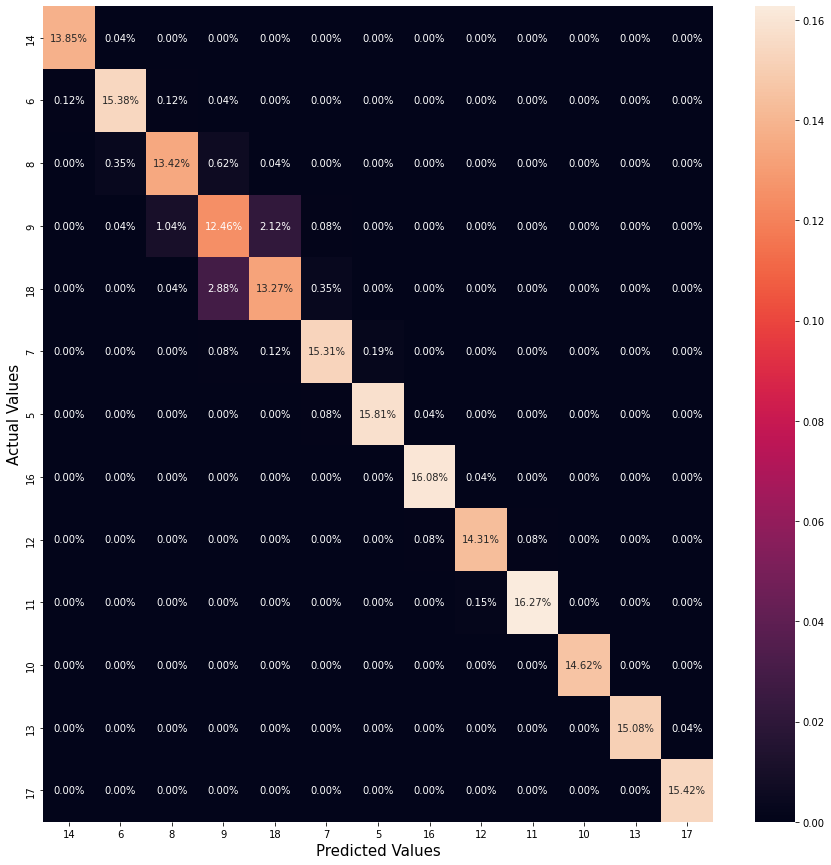

In [25]:
Decision_Tree = DecisionTreeClassifier()

Decision_Tree = model_Trainer(Decision_Tree , "Decision_Tree")

              precision    recall  f1-score   support

           5       1.00      0.99      0.99       361
           6       0.99      0.99      0.99       407
           7       0.89      0.96      0.92       375
           8       0.78      0.82      0.80       409
           9       0.89      0.78      0.83       430
          10       0.94      0.96      0.95       408
          11       0.99      0.97      0.98       414
          12       1.00      0.99      0.99       419
          13       0.98      0.99      0.99       376
          14       1.00      1.00      1.00       427
          16       1.00      1.00      1.00       380
          17       1.00      1.00      1.00       393
          18       1.00      1.00      1.00       401

    accuracy                           0.96      5200
   macro avg       0.96      0.96      0.96      5200
weighted avg       0.96      0.96      0.96      5200



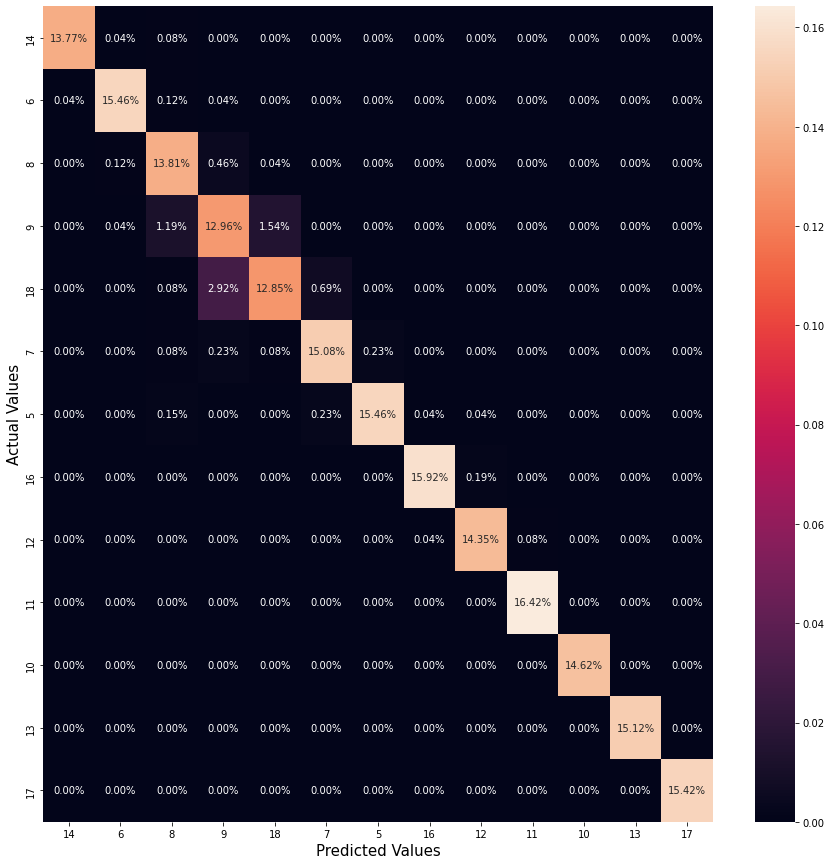

In [26]:
# Create a object of model
Random_Forest = RandomForestClassifier()

# Train the model and generate report
Decision_Tree_Tuned = model_Trainer(Random_Forest, "Random_Forest")

              precision    recall  f1-score   support

           5       1.00      0.98      0.99       361
           6       0.97      0.97      0.97       407
           7       0.89      0.94      0.91       375
           8       0.77      0.81      0.79       409
           9       0.87      0.75      0.80       430
          10       0.87      0.87      0.87       408
          11       0.88      0.95      0.91       414
          12       1.00      0.98      0.99       419
          13       0.96      0.95      0.96       376
          14       0.97      0.98      0.98       427
          16       1.00      1.00      1.00       380
          17       1.00      0.99      1.00       393
          18       1.00      0.99      0.99       401

    accuracy                           0.93      5200
   macro avg       0.94      0.94      0.94      5200
weighted avg       0.94      0.93      0.93      5200



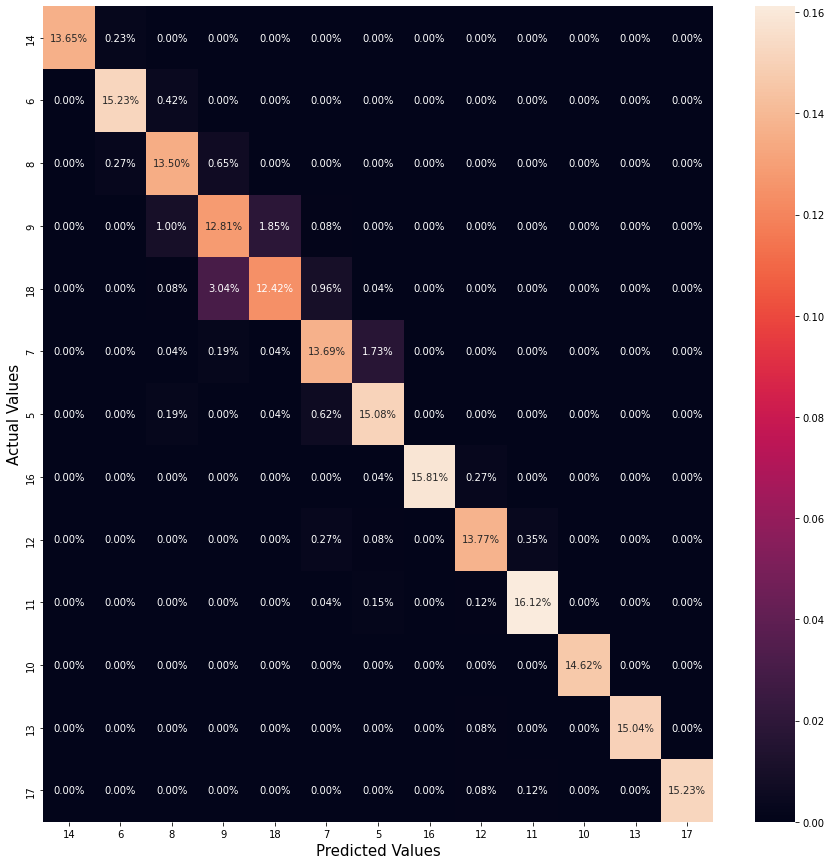

In [27]:
svm_classifier = SVC(probability=True)

# Train the model and generate report
svm_classifier = model_Trainer(svm_classifier, "svm_classifier")

              precision    recall  f1-score   support

           5       0.00      0.00      0.00       361
           6       0.00      0.00      0.00       407
           7       0.00      0.00      0.00       375
           8       0.21      0.86      0.33       409
           9       0.00      0.00      0.00       430
          10       0.46      0.56      0.51       408
          11       0.68      0.98      0.80       414
          12       0.00      0.00      0.00       419
          13       0.31      1.00      0.47       376
          14       0.00      0.00      0.00       427
          16       0.32      1.00      0.49       380
          17       0.00      0.00      0.00       393
          18       0.00      0.00      0.00       401

    accuracy                           0.34      5200
   macro avg       0.15      0.34      0.20      5200
weighted avg       0.15      0.34      0.20      5200



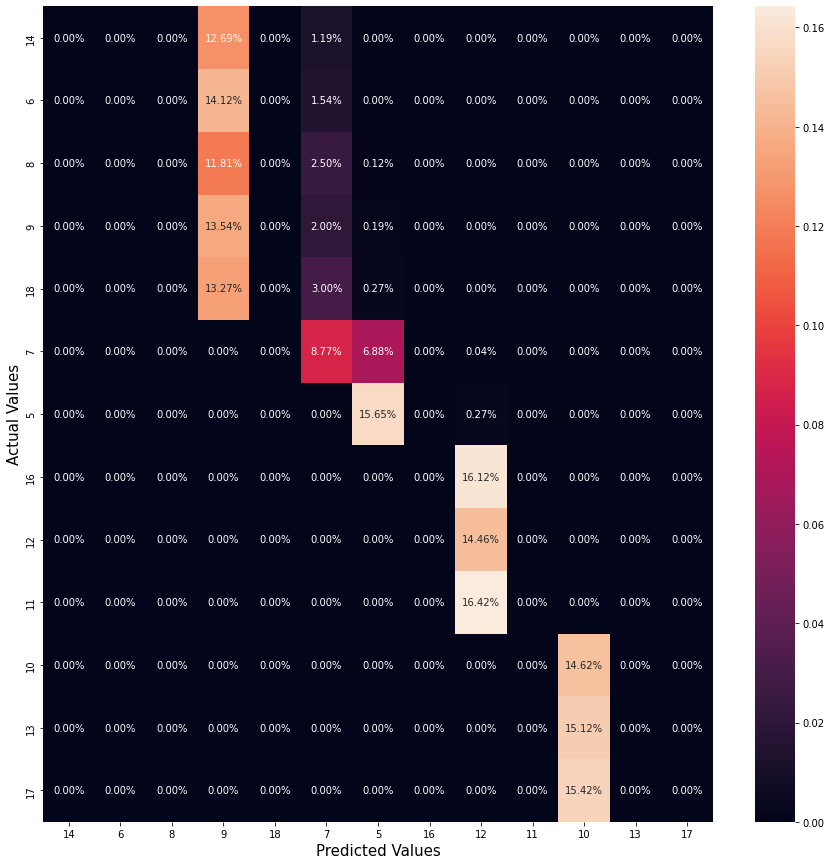

In [28]:
AdaBoost_Classifier = AdaBoostClassifier()

AdaBoost_Classifier = model_Trainer(AdaBoost_Classifier, "AdaBoost_Classifier")

### 4.3 deep Learning Approaches

In [29]:
# convert the data from the numpy array to tensor

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float().reshape(-1,1)

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float().reshape(-1,1)

In [30]:
# Convert the splitted data of tensors to TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# From the tensordata set to mini batches 
train_data = DataLoader( train_data, 
                        batch_size= int(X_train.shape[0]/8),  # the data set will be devided into 8 equal mini batches
                       shuffle= True, 
                       drop_last= True)

test_data = DataLoader( test_data, shuffle= True )

In [53]:
# building ann classifier class 

class ANNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input layer
        self.input = nn.Linear(X_train.shape[1], 16)
        
        # dense layers 
        self.dense_1 = nn.Linear(16, 32)
        self.dense_1_BN = nn.BatchNorm1d(32)
        
        self.dense_2 = nn.Linear(32, 64)
        self.dense_2_BN = nn.BatchNorm1d(64)
        
        
        self.dense_3 = nn.Linear(64, 128)
        self.dense_3_BN = nn.BatchNorm1d(128)
        
        
        # output layer
        self.output = nn.Linear(128,13)
        
    def forward(self,x):
        
        # input layer
        x = F.leaky_relu(self.input(x))
        # dense layer 1 
        x = self.dense_1(x)
        x = F.leaky_relu(self.dense_1_BN(x))
        x = F.dropout(x, p = 0.5 , training= self.training )
        
        
        # dense layer 2
        x = self.dense_2(x)
        x = F.leaky_relu(self.dense_2_BN(x))
        x = F.dropout(x, p = 0.6 , training= self.training )
        
        
        # dense layer 3 
        x = self.dense_3(x)
        x = F.leaky_relu(self.dense_3_BN(x))
        x = F.dropout(x, p = 0.5 , training= self.training )
        
        
        # output layer
        x = self.output(x)  
        
        return x

In [54]:
# create a instance of a class
model = ANNClassifier()
print(model)

# loss function 
loss_fun = nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01)  # L2 regularization

ANNClassifier(
  (input): Linear(in_features=32, out_features=16, bias=True)
  (dense_1): Linear(in_features=16, out_features=32, bias=True)
  (dense_1_BN): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_2): Linear(in_features=32, out_features=64, bias=True)
  (dense_2_BN): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_3): Linear(in_features=64, out_features=128, bias=True)
  (dense_3_BN): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=128, out_features=13, bias=True)
)


In [55]:
loss_fun( model(X_train),y_train.squeeze(dim = 1).long() )

IndexError: Target 14 is out of bounds.

In [48]:
def model_train_and_validation(model, epoch):
    
    train_acc = []
    test_acc = []
    train_loss = [] #torch.zeros(epoch)
    
    # loop over every epoch
    for epochi in range(epoch):
        
        # loop over traing data batches
        bach_acc = []
        bach_loss = []
        for x,y in train_data: 
            
            # forward propogation
            yHat = model(x) 
            
            # loss 
            loss = loss_fun( model(x),y.squeeze(dim = -1).long() )
            bach_loss.append(loss.detach().numpy())
            
            
            # back propogation 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            # compute batch accuracy 
            bach_acc.append( accuracy_score( y, torch.argmax( yHat, dim = 1 )  ) )#
            
            
        # compute training accuracy and loss
        train_acc.append(np.mean(bach_acc))
        train_loss.append( np.mean(bach_loss) )
        
        # evaluation mode on
        model.eval()
        
        x,y = next(iter( test_data ) )
        yHat = torch.log_softmax( model(x), dim =1 ) #
        test_acc.append( accuracy_score(  y, torch.argmax( yHat, dim = 1 )   )          ) #
        
        
        #
        
        
        # model back to train mode
        model.train()
        
        print(f" Epoch : {epochi}, Train Acc : {train_acc[epochi]},   Train Loss : {train_loss[epochi]},  ")
        
    model.eval()  
    return train_acc, train_loss, test_acc

In [49]:
train_acc, train_loss, test_acc = model_train_and_validation(model, 100)

IndexError: Target 18 is out of bounds.

In [198]:
plt.figure(figsize= (20,7))

plt.plot(train_acc, label = "train accuracy")
plt.plot(test_acc, label = "test accuracy")
plt.plot( train_loss, label = "test loss" )
plt.legend()
plt.grid()
plt.show()

In [58]:
model = Sequential()
model.add( Dense( 16, activation= 'relu', input_dim = X_train.shape[1]))
model.add(BatchNormalization() )
model.add(Dropout())

model.add( Dense( 32, activation= 'relu'))
model.add(BatchNormalization() )
model.add(Dropout())

model.add( Dense( 64, activation= 'relu'))
model.add(BatchNormalization() )

model.add( Dense( 13, activation= 'softmax', input_dim = X_train.shape[1]))


TypeError: 'module' object is not callable

# Generate Predictions 

In [199]:
# Load the test data points 

df = pd.read_csv("cs98x-22-dl-task2/test.csv")
Id = df.iloc[:, 0].values.astype(np.int32)
df.drop( labels= ['id'], axis= 1, inplace= True )
df = df.dropna()
df.head()

In [209]:
# Label Encode the Values

for i in df.select_dtypes(np.object_).columns:
    
    df[i] = la_dct[i].transform(df[i].values)
    
df.head()

In [211]:
# scaling and normalisation 


independent_fea = df.columns

for i in independent_fea:
    df[i] = scalar.transform(df[i].values.reshape(-1,1))

In [ ]:
# shuffle the data 
df = df.sample(n = data.shape[0])

In [ ]:
# Store the results in the dataFrame
res = pd.DataFrame()
res['id'] = Id

res['diagnosis'] = pd.DataFrame(   model(torch.tensor(df.values).float()).detach().numpy()  )
res = res.dropna()
# Save the csv file with name as "results" and file extention ".csv"
res.to_csv( 'neural_network_1.csv' , index = False)